# Introduction to Deep Learning with PyTorch- Section One
In this notebook, you'll get introduced to [PyTorch](http://pytorch.org/), a framework for building and training neural networks. PyTorch in a lot of ways behaves like the arrays you love from Numpy. These Numpy arrays, after all, are just tensors. PyTorch takes these tensors and makes it simple to move them to GPUs for the faster processing needed when training neural networks. It also provides a module that automatically calculates gradients (for backpropagation!) and another module specifically for building neural networks. All together, PyTorch ends up being more coherent with Python and the Numpy/Scipy stack compared to TensorFlow and other frameworks.

## Neural Networks

Deep Learning is based on artificial neural networks which have been around in some form since the late 1950s. The networks are built from individual parts approximating neurons, typically called units or simply "neurons." Each unit has some number of weighted inputs. These weighted inputs are summed together (a linear combination) then passed through an activation function to get the unit's output.

<img src="assets/simple_neuron.png" width=400px>

Mathematically this looks like: 

$$
\begin{align}
y &= f(w_1 x_1 + w_2 x_2 + b) \\
y &= f\left(\sum_i w_i x_i +b \right)
\end{align}
$$

With vectors this is the dot/inner product of two vectors:

$$
h = \begin{bmatrix}
x_1 \, x_2 \cdots  x_n
\end{bmatrix}
\cdot 
\begin{bmatrix}
           w_1 \\
           w_2 \\
           \vdots \\
           w_n
\end{bmatrix}
$$

## Tensors

It turns out neural network computations are just a bunch of linear algebra operations on *tensors*, a generalization of matrices. A vector is a 1-dimensional tensor, a matrix is a 2-dimensional tensor, an array with three indices is a 3-dimensional tensor (RGB color images for example). The fundamental data structure for neural networks are tensors and PyTorch (as well as pretty much every other deep learning framework) is built around tensors.

<img src="assets/tensor_examples.svg" width=600px>

With the basics covered, it's time to explore how we can use PyTorch to build a simple neural network.

In [4]:
import torch

In [5]:
def activation(x):
    '''
    x:torch.Tensor
    '''
    return 1/(1+torch.exp(-x))

In [6]:
# Genarate some data
torch.manual_seed(7)# Set the random seed so things are predictable

# Features are 3 random normal variables
features = torch.randn((1, 5))

# True weights for our data, random normal variables again
weights = torch.randn_like(features)

# and a true bias term
bias = torch.randn((1, 1))

print(features, features.shape)
print(weights, weights.shape)

tensor([[-0.1468,  0.7861,  0.9468, -1.1143,  1.6908]]) torch.Size([1, 5])
tensor([[-0.8948, -0.3556,  1.2324,  0.1382, -1.6822]]) torch.Size([1, 5])


Above I generated data we can use to get the output of our simple network. This is all just random for now, going forward we'll start using normal data. Going through each relevant line:

`features = torch.randn((1, 5))` creates a tensor with shape `(1, 5)`, one row and five columns, that contains values randomly distributed according to the normal distribution with a mean of zero and standard deviation of one. 

`weights = torch.randn_like(features)` creates another tensor with the same shape as `features`, again containing values from a normal distribution.

Finally, `bias = torch.randn((1, 1))` creates a single value from a normal distribution.

PyTorch tensors can be added, multiplied, subtracted, etc, just like Numpy arrays. In general, you'll use PyTorch tensors pretty much the same way you'd use Numpy arrays. They come with some nice benefits though such as GPU acceleration which we'll get to later. For now, use the generated data to calculate the output of this simple single layer network. 
> **Exercise**: Calculate the output of the network with input features `features`, weights `weights`, and bias `bias`. Similar to Numpy, PyTorch has a [`torch.sum()`](https://pytorch.org/docs/stable/torch.html#torch.sum) function, as well as a `.sum()` method on tensors, for taking sums. Use the function `activation` defined above as the activation function.

In [7]:
y = activation(torch.sum(features * weights) + bias)
print(y)
y = activation((features * weights).sum() + bias)
print(y)

tensor([[ 0.1595]])
tensor([[ 0.1595]])


You can do the multiplication and sum in the same operation using a matrix multiplication. In general, you'll want to use matrix multiplications since they are more efficient and accelerated using modern libraries and high-performance computing on GPUs.

Here, we want to do a matrix multiplication of the features and the weights. For this we can use [`torch.mm()`](https://pytorch.org/docs/stable/torch.html#torch.mm) or [`torch.matmul()`](https://pytorch.org/docs/stable/torch.html#torch.matmul) which is somewhat more complicated and supports broadcasting. If we try to do it with `features` and `weights` as they are, we'll get an error

```python
>> torch.mm(features, weights)

---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
<ipython-input-13-15d592eb5279> in <module>()
----> 1 torch.mm(features, weights)

RuntimeError: size mismatch, m1: [1 x 5], m2: [1 x 5] at /Users/soumith/minicondabuild3/conda-bld/pytorch_1524590658547/work/aten/src/TH/generic/THTensorMath.c:2033
```

As you're building neural networks in any framework, you'll see this often. Really often. What's happening here is our tensors aren't the correct shapes to perform a matrix multiplication. Remember that for matrix multiplications, the number of columns in the first tensor must equal to the number of rows in the second column. Both `features` and `weights` have the same shape, `(1, 5)`. This means we need to change the shape of `weights` to get the matrix multiplication to work.

**Note:** To see the shape of a tensor called `tensor`, use `tensor.shape`. If you're building neural networks, you'll be using this method often.

There are a few options here: [`weights.reshape()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.reshape), [`weights.resize_()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.resize_), and [`weights.view()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view).

* `weights.reshape(a, b)` will return a new tensor with the same data as `weights` with size `(a, b)` sometimes, and sometimes a clone, as in it copies the data to another part of memory.
* `weights.resize_(a, b)` returns the same tensor with a different shape. However, if the new shape results in fewer elements than the original tensor, some elements will be removed from the tensor (but not from memory). If the new shape results in more elements than the original tensor, new elements will be uninitialized in memory. Here I should note that the underscore at the end of the method denotes that this method is performed **in-place**. Here is a great forum thread to [read more about in-place operations](https://discuss.pytorch.org/t/what-is-in-place-operation/16244) in PyTorch.
* `weights.view(a, b)` will return a new tensor with the same data as `weights` with size `(a, b)`.

I usually use `.view()`, but any of the three methods will work for this. So, now we can reshape `weights` to have five rows and one column with something like `weights.view(5, 1)`.

> **Exercise**: Calculate the output of our little network using matrix multiplication.

In [8]:
y = activation(torch.mm(features, weights.view(5, 1))+ bias)
y

tensor([[ 0.1595]])

### Stack them up!

That's how you can calculate the output for a single neuron. The real power of this algorithm happens when you start stacking these individual units into layers and stacks of layers, into a network of neurons. The output of one layer of neurons becomes the input for the next layer. With multiple input units and output units, we now need to express the weights as a matrix.

<img src='assets/multilayer_diagram_weights.png' width=450px>

The first layer shown on the bottom here are the inputs, understandably called the **input layer**. The middle layer is called the **hidden layer**, and the final layer (on the right) is the **output layer**. We can express this network mathematically with matrices again and use matrix multiplication to get linear combinations for each unit in one operation. For example, the hidden layer ($h_1$ and $h_2$ here) can be calculated 

$$
\vec{h} = [h_1 \, h_2] = 
\begin{bmatrix}
x_1 \, x_2 \cdots \, x_n
\end{bmatrix}
\cdot 
\begin{bmatrix}
           w_{11} & w_{12} \\
           w_{21} &w_{22} \\
           \vdots &\vdots \\
           w_{n1} &w_{n2}
\end{bmatrix}
$$

The output for this small network is found by treating the hidden layer as inputs for the output unit. The network output is expressed simply

$$
y =  f_2 \! \left(\, f_1 \! \left(\vec{x} \, \mathbf{W_1}\right) \mathbf{W_2} \right)
$$

In [9]:
# Generate some data
torch.manual_seed(7)

# 3 normal random variables 
features = torch.randn((1,3))

# Define the size of each layer in our network
n_input = features.shape[1]
n_hidden = 2
n_output = 1

# Weights for inputs to hidden layer

W1 = torch.randn(n_input, n_hidden)
W2 = torch.randn(n_hidden, n_output)

B1 = torch.randn(1, n_hidden)
B2 = torch.randn(1, n_output)
print(features)
print(W1.view(3,2))

tensor([[-0.1468,  0.7861,  0.9468]])
tensor([[-1.1143,  1.6908],
        [-0.8948, -0.3556],
        [ 1.2324,  0.1382]])


In [10]:
print(W1, W2, B1, B2)

tensor([[-1.1143,  1.6908],
        [-0.8948, -0.3556],
        [ 1.2324,  0.1382]]) tensor([[-1.6822],
        [ 0.3177]]) tensor([[ 0.1328,  0.1373]]) tensor([[ 0.2405]])


In [11]:
out = activation(torch.mm(features, W1.view(3, 2))+ B1)
print(out)
y = activation(torch.mm(out, W2.view(2, 1))+ B2)
print(y)

tensor([[ 0.6813,  0.4355]])
tensor([[ 0.3171]])


## Numpy to Torch and back

Special bonus section! PyTorch has a great feature for converting between Numpy arrays and Torch tensors. To create a tensor from a Numpy array, use `torch.from_numpy()`. To convert a tensor to a Numpy array, use the `.numpy()` method.

In [12]:
import numpy as np
a = np.random.rand(4, 3)
a

array([[ 0.57431598,  0.82992268,  0.45339725],
       [ 0.87006256,  0.28012114,  0.62750521],
       [ 0.25830454,  0.86526194,  0.12925551],
       [ 0.040952  ,  0.73490726,  0.76746961]])

In [13]:
b = torch.from_numpy(a)
b

tensor([[ 0.5743,  0.8299,  0.4534],
        [ 0.8701,  0.2801,  0.6275],
        [ 0.2583,  0.8653,  0.1293],
        [ 0.0410,  0.7349,  0.7675]], dtype=torch.float64)

In [14]:
b.numpy()


array([[ 0.57431598,  0.82992268,  0.45339725],
       [ 0.87006256,  0.28012114,  0.62750521],
       [ 0.25830454,  0.86526194,  0.12925551],
       [ 0.040952  ,  0.73490726,  0.76746961]])

In [15]:
b

tensor([[ 0.5743,  0.8299,  0.4534],
        [ 0.8701,  0.2801,  0.6275],
        [ 0.2583,  0.8653,  0.1293],
        [ 0.0410,  0.7349,  0.7675]], dtype=torch.float64)

In [16]:
b.mul_(2)

tensor([[ 1.1486,  1.6598,  0.9068],
        [ 1.7401,  0.5602,  1.2550],
        [ 0.5166,  1.7305,  0.2585],
        [ 0.0819,  1.4698,  1.5349]], dtype=torch.float64)

In [17]:
a

array([[ 1.14863197,  1.65984535,  0.9067945 ],
       [ 1.74012512,  0.56024228,  1.25501042],
       [ 0.51660908,  1.73052388,  0.25851103],
       [ 0.081904  ,  1.46981453,  1.53493922]])

The memory is shared between the Numpy array and Torch tensor, so if you change the values in-place of one object, the other will change as well.

# Neural networks with PyTorch

Deep learning networks tend to be massive with dozens or hundreds of layers, that's where the term "deep" comes from. You can build one of these deep networks using only weight matrices as we did in the previous notebook, but in general it's very cumbersome and difficult to implement. PyTorch has a nice module `nn` that provides a nice way to efficiently build large neural networks.

In [18]:
import helper
import matplotlib.pyplot as plt


Now we're going to build a larger network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

<img src='assets/mnist.png'>

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [19]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Processing...
Done!


We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. Later, we'll use this to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

You'll notice I created the `trainloader` with a batch size of 64, and `shuffle=True`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to shuffle the dataset every time we start going through the data loader again. But here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size `(64, 1, 28, 28)`. So, 64 images per batch, 1 color channel, and 28x28 images.

In [20]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


torch.Size([1, 28, 28])


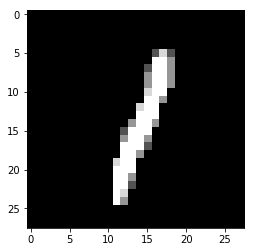

In [21]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');
print(images[1].shape)



First, let's try to build a simple network for this dataset using weight matrices and matrix multiplications. Then, we'll see how to do it using PyTorch's `nn` module which provides a much more convenient and powerful method for defining network architectures.

The networks you've seen so far are called *fully-connected* or *dense* networks. Each unit in one layer is connected to each unit in the next layer. In fully-connected networks, the input to each layer must be a one-dimensional vector (which can be stacked into a 2D tensor as a batch of multiple examples). However, our images are 28x28 2D tensors, so we need to convert them into 1D vectors. Thinking about sizes, we need to convert the batch of images with shape `(64, 1, 28, 28)` to a have a shape of `(64, 784)`, 784 is 28 times 28. This is typically called *flattening*, we flattened the 2D images into 1D vectors.

Previously you built a network with one output unit. Here we need 10 output units, one for each digit. We want our network to predict the digit shown in an image, so what we'll do is calculate probabilities that the image is of any one digit or class. This ends up being a discrete probability distribution over the classes (digits) that tells us the most likely class for the image. That means we need 10 output units for the 10 classes (digits). We'll see how to convert the network output into a probability distribution next.

> **Exercise:** Flatten the batch of images `images`. Then build a multi-layer network with 784 input units, 256 hidden units, and 10 output units using random tensors for the weights and biases. For now, use a sigmoid activation for the hidden layer. Leave the output layer without an activation, we'll add one that gives us a probability distribution next.

In [22]:
def activation(x):
    return 1/(1+torch.exp(-x))

#flatten the input images
inputs = images.view(images.shape[0], -1)# when you put the -1 in it, it'll try to make a same shape as before.

#create parameters
w1 = torch.randn(784, 256)
b1 = torch.randn(256)

w2 = torch.randn(256, 10)
b2 = torch.randn(10)

h = activation(torch.mm(inputs, w1)+b1)

out = torch.mm(h, w2)+b2

print(out[0])# 64 output with 10 probabilities


tensor([  6.8753,   4.2733,  -5.6010,  -0.5069,  -0.5756,  13.4175,
         -3.5667,  -3.5502,  -1.3397,  -0.1160])


Now we have 10 outputs for our network. We want to pass in an image to our network and get out a probability distribution over the classes that tells us the likely class(es) the image belongs to. Something that looks like this:
<img src='assets/image_distribution.png' width=500px>

Here we see that the probability for each class is roughly the same. This is representing an untrained network, it hasn't seen any data yet so it just returns a uniform distribution with equal probabilities for each class.

To calculate this probability distribution, we often use the [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function). Mathematically this looks like

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

What this does is squish each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilites sum up to one.

> **Exercise:** Implement a function `softmax` that performs the softmax calculation and returns probability distributions for each example in the batch. Note that you'll need to pay attention to the shapes when doing this. If you have a tensor `a` with shape `(64, 10)` and a tensor `b` with shape `(64,)`, doing `a/b` will give you an error because PyTorch will try to do the division across the columns (called broadcasting) but you'll get a size mismatch. The way to think about this is for each of the 64 examples, you only want to divide by one value, the sum in the denominator. So you need `b` to have a shape of `(64, 1)`. This way PyTorch will divide the 10 values in each row of `a` by the one value in each row of `b`. Pay attention to how you take the sum as well. You'll need to define the `dim` keyword in `torch.sum`. Setting `dim=0` takes the sum across the rows while `dim=1` takes the sum across the columns.

In [23]:
 def softmax(x):
        return torch.exp(x)/torch.sum(torch.exp(x), dim =1).view(-1,1)
    
probabilities = softmax(out)

print(probabilities.shape)
print(probabilities.sum(dim = 1).shape)

torch.Size([64, 10])
torch.Size([64])


## Building networks with PyTorch

PyTorch provides a module `nn` that makes building networks much simpler. Here I'll show you how to build the same one as above with 784 inputs, 256 hidden units, 10 output units and a softmax output.

In [24]:
from torch import nn

In [25]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        #input to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        #output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        #Define sigmoid activation and softmax output
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
        def forward(self, x):
            # Pass the input tensor through each of our operations
            x = self.hidden(x)
            x = self.sigmoid(x)
            x = self.output(x)
            x = self.softmax(x)
            
            return x

Let's go through this bit by bit.

```python
class Network(nn.Module):
```

Here we're inheriting from `nn.Module`. Combined with `super().__init__()` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from `nn.Module` when you're creating a class for your network. The name of the class itself can be anything.

```python
self.hidden = nn.Linear(784, 256)
```

This line creates a module for a linear transformation, $x\mathbf{W} + b$, with 784 inputs and 256 outputs and assigns it to `self.hidden`. The module automatically creates the weight and bias tensors which we'll use in the `forward` method. You can access the weight and bias tensors once the network (`net`) is created with `net.hidden.weight` and `net.hidden.bias`.

```python
self.output = nn.Linear(256, 10)
```

Similarly, this creates another linear transformation with 256 inputs and 10 outputs.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

Here I defined operations for the sigmoid activation and softmax output. Setting `dim=1` in `nn.Softmax(dim=1)` calculates softmax across the columns.

```python
def forward(self, x):
```

PyTorch networks created with `nn.Module` must have a `forward` method defined. It takes in a tensor `x` and passes it through the operations you defined in the `__init__` method.

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

Here the input tensor `x` is passed through each operation a reassigned to `x`. We can see that the input tensor goes through the hidden layer, then a sigmoid function, then the output layer, and finally the softmax function. It doesn't matter what you name the variables here, as long as the inputs and outputs of the operations match the network architecture you want to build. The order in which you define things in the `__init__` method doesn't matter, but you'll need to sequence the operations correctly in the `forward` method.

Now we can create a `Network` object.

In [26]:
# Create the network and look at it's text representation
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax()
)

You can define the network somewhat more concisely and clearly using the `torch.nn.functional` module. This is the most common way you'll see networks defined as many operations are simple element-wise functions. We normally import this module as `F`, `import torch.nn.functional as F`.

In [27]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Input to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units 
        self.output = nn.Linear(256, 10)
        
        def forward(self, x):
            # Hidden layer with sigmoid activation
            x = F.sigmoid(self.hidden(x))
            # Output layer with softmax activation 
            x = F.softmax(self.output(x), dim =1)
            
            return x
        

### Activation functions

So far we've only been looking at the softmax activation, but in general any function can be used as an activation function. The only requirement is that for a network to approximate a non-linear function, the activation functions must be non-linear. Here are a few more examples of common activation functions: Tanh (hyperbolic tangent), and ReLU (rectified linear unit).

<img src="assets/activation.png" width=700px>

In practice, the ReLU function is used almost exclusively as the activation function for hidden layers.

### Your Turn to Build a Network

<img src="assets/mlp_mnist.png" width=600px>

> **Exercise:** Create a network with 784 input units, a hidden layer with 128 units and a ReLU activation, then a hidden layer with 64 units and a ReLU activation, and finally an output layer with a softmax activation as shown above. You can use a ReLU activation with the `nn.ReLU` module or `F.relu` function.

In [28]:
## Solution

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Initializing weights and biases

The weights and such are automatically initialized for you, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, you can get them with `model.fc1.weight` for instance.

In [29]:
print(model.fc1.weight.shape)
print(model.fc1.bias.shape)

torch.Size([128, 784])
torch.Size([128])


For custom initialization, we want to modify these tensors in place. These are actually autograd *Variables*, so we need to get back the actual tensors with `model.fc1.weight.data`. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.

In [30]:
# Set biases to all zeros
model.fc1.bias.data

tensor(1.00000e-02 *
       [-0.7431,  0.2301,  1.6740,  2.7051,  0.6252, -0.1610,  2.0617,
        -0.1641,  0.3622, -0.7649,  1.0525, -3.0952, -0.2539, -0.9378,
         3.4697, -2.9377, -0.6113,  0.5249,  0.5240,  1.1483,  2.2860,
        -1.3353, -0.0996,  0.0615, -3.1515,  1.0033, -2.8843,  1.7604,
         3.4325,  2.5382, -0.3251,  0.7631, -0.7682, -0.8566,  2.0864,
        -2.0984,  2.8646,  1.1656, -1.8832,  0.1338, -1.0488, -2.1127,
         0.0880,  0.2161, -2.4469,  2.2210, -0.5025, -2.6257, -2.4667,
        -2.8893,  2.5986,  0.2493,  0.3597, -3.1645,  2.8668, -1.1518,
         2.5710,  2.0573, -0.4425, -1.8080,  2.7289,  2.8354,  0.5891,
        -2.4242, -1.2957,  0.2273,  1.5842,  2.8071,  1.8272,  0.6003,
        -2.6663, -2.9327, -3.0711, -1.7219,  0.6364, -2.3769, -1.0427,
         1.8957, -2.9660, -2.1548, -1.9090,  1.4173,  0.4880,  2.8593,
        -0.5192,  0.4613,  2.5323,  2.2451,  1.8837,  0.0520, -2.5246,
        -0.4242,  2.9478, -2.8304, -3.3281,  1.9605, -2.

In [31]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [32]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data

tensor(1.00000e-02 *
       [[ 1.5876,  2.6843, -0.3311,  ...,  0.1889,  1.1872, -3.0820],
        [ 1.9416,  0.5454, -0.3803,  ..., -0.2432, -1.3721,  2.6308],
        [-1.5792,  2.5486, -2.7145,  ...,  1.2134,  1.4301, -2.5477],
        ...,
        [-2.9549,  0.5695, -2.2583,  ...,  1.3896, -1.8033, -1.6969],
        [ 2.7479, -2.7414, -0.2829,  ...,  0.2930, -0.2163, -0.4633],
        [-0.8959,  1.1450, -3.0171,  ..., -1.2313, -0.9047, -1.9414]])

In [33]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 5.2724e-03,  5.4868e-03, -1.8894e-03,  ...,  6.8196e-03,
          7.4862e-03,  6.9197e-03],
        [ 5.2883e-03, -6.2293e-03, -7.7408e-03,  ...,  1.2493e-02,
          1.3777e-02, -8.1237e-03],
        [-1.6004e-04, -1.8321e-03,  8.8960e-03,  ..., -1.4534e-02,
          7.7116e-03,  2.7435e-04],
        ...,
        [-5.4804e-03,  1.1587e-02, -3.7657e-03,  ...,  1.8455e-03,
         -4.7533e-03, -1.6920e-02],
        [-6.7880e-04,  1.6908e-02,  4.2577e-03,  ..., -1.7138e-03,
          1.2543e-02, -1.1571e-02],
        [ 6.9116e-04,  3.1802e-03,  1.3073e-02,  ...,  6.0324e-03,
          4.4465e-03,  9.8246e-03]])

### Forward pass

Now that we have a network, let's see what happens when we pass in an image.

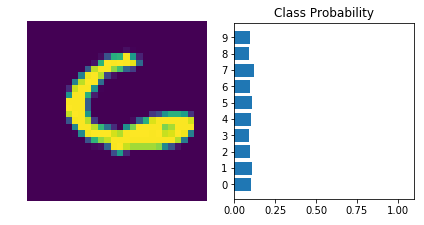

In [34]:
# Grab some data

dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector , new shape is (batch size,
#   color channels, image pixels)
images.resize_(images.shape[0], 1, 784)
# Forward pass through the network

img_idx = 1

ps = model.forward(images[img_idx, :1])

img = images[img_idx]
helper.view_classify(img.view(1,28,28), ps)

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

### Using `nn.Sequential`

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

In [35]:
 # Hyperparameters for our Network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10


# Build a feed-forward network

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim =1)
                     )

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)


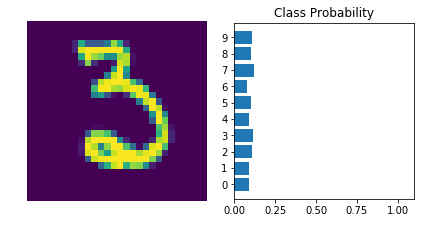

In [36]:
# Forward pass through the network and display output

images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0, :])
helper.view_classify(images[0].view(1, 28, 28), ps)

The operations are availble by passing in the appropriate index. For example, if you want to get first Linear operation and look at the weights, you'd use `model[0]`.

In [37]:
print(model[0])
print(model[0].weight)
print(model[0].weight.shape)

Linear(in_features=784, out_features=128, bias=True)
Parameter containing:
tensor([[-3.3930e-02,  1.1833e-02,  2.9027e-03,  ..., -2.6841e-02,
          6.2824e-03,  2.6160e-02],
        [ 2.7242e-02,  3.3363e-03, -5.0062e-03,  ...,  1.4984e-02,
          1.8337e-02, -2.0277e-02],
        [ 2.5399e-02,  2.3192e-04,  3.2993e-02,  ...,  1.2123e-02,
         -2.8349e-03,  1.0603e-02],
        ...,
        [-2.9491e-02, -2.6549e-02,  1.7404e-02,  ...,  1.5144e-02,
          3.5190e-02,  1.2627e-02],
        [-7.7132e-03,  2.3159e-02, -2.8670e-02,  ..., -3.3898e-02,
         -1.6165e-03,  1.9434e-02],
        [ 3.2463e-02,  2.7001e-04,  1.5757e-02,  ..., -8.1911e-03,
         -3.4630e-02, -1.0337e-02]])
torch.Size([128, 784])


You can also pass in an `OrderedDict` to name the individual layers and operations, instead of using incremental integers. Note that dictionary keys must be unique, so _each operation must have a different name_.

In [38]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

Now you can access layers either by integer or the name

In [39]:
print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


In the next notebook, we'll see how we can train a neural network to accuractly predict the numbers appearing in the MNIST images.

----------------------------------------------

# Training Neural Networks

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets/gradient_descent.png' width=350px>

## Backpropagation

For single layer networks, gradient descent is straightforward to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks.

Training multilayer networks is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='assets/backprop_diagram.png' width=550px>

In the forward pass through the network, our data and operations go from bottom to top here. We pass the input $x$ through a linear transformation $L_1$ with weights $W_1$ and biases $b_1$. The output then goes through the sigmoid operation $S$ and another linear transformation $L_2$. Finally we calculate the loss $\ell$. We use the loss as a measure of how bad the network's predictions are. The goal then is to adjust the weights and biases to minimize the loss.

To train the weights with gradient descent, we propagate the gradient of the loss backwards through the network. Each operation has some gradient between the inputs and outputs. As we send the gradients backwards, we multiply the incoming gradient with the gradient for the operation. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

**Note:** I'm glossing over a few details here that require some knowledge of vector calculus, but they aren't necessary to understand what's going on.

We update our weights using this gradient with some learning rate $\alpha$. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

The learning rate $\alpha$ is set such that the weight update steps are small enough that the iterative method settles in a minimum.

## Losses in PyTorch

Let's start by seeing how we calculate the loss with PyTorch. Through the `nn` module, PyTorch provides losses such as the cross-entropy loss (`nn.CrossEntropyLoss`). You'll usually see the loss assigned to `criterion`. As noted in the last part, with a classification problem such as MNIST, we're using the softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss. To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.

Something really important to note here. Looking at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [40]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5),
                                                   (0.5, 0.5, 0.5))])


# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [41]:
# Build a feed-forward model

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data

images, labels = next(iter(trainloader))

#Flatten images
images = images.view(images.shape[0], -1)

#Forwar pass, get our logits

logits = model(images)
print(logits.shape)
print(labels)

# Calculate the loss with the logits and the labels

loss = criterion(logits, labels)

print(loss)

torch.Size([64, 10])
tensor([ 1,  4,  0,  4,  6,  2,  9,  9,  6,  2,  4,  9,  2,  1,
         3,  7,  4,  9,  9,  5,  1,  0,  2,  5,  4,  3,  3,  4,
         5,  3,  0,  2,  0,  8,  1,  1,  3,  6,  0,  6,  8,  5,
         5,  9,  7,  0,  6,  3,  4,  2,  4,  8,  8,  4,  8,  1,
         2,  2,  3,  4,  3,  4,  1,  8])
tensor(2.3119)


In my experience it's more convenient to build the model with a log-softmax output using `nn.LogSoftmax` or `F.log_softmax` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). Then you can get the actual probabilites by taking the exponential `torch.exp(output)`. With a log-softmax output, you want to use the negative log likelihood loss, `nn.NLLLoss` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).

>**Exercise:** Build a model that returns the log-softmax as the output and calculate the loss using the negative log likelihood loss.

In [42]:
## Solution

# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our log-probabilities
logps = model(images)
# Calculate the loss with the logps and the labels
loss = criterion(logps, labels)

print(loss)


tensor(2.3155)


## Autograd

Now that we know how to calculate a loss, how do we use it to perform backpropagation? Torch provides a module, `autograd`, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [43]:
x = torch.randn(2,2, requires_grad= True)
x

tensor([[-1.2157, -0.6366],
        [ 0.5047, -2.1685]])

In [44]:
y = x**2
y

tensor([[ 1.4780,  0.4052],
        [ 0.2548,  4.7023]])

Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [45]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

In [46]:
z = y.mean()
z

tensor(1.7101)

The autgrad module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [47]:
print(z.grad_fn)

You can check the gradients for `x` and `y` but they are empty currently.

In [48]:
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [49]:
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.6079, -0.3183],
        [ 0.2524, -1.0842]])
tensor([[-0.6079, -0.3183],
        [ 0.2524, -1.0842]])


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the loss, then, go backwards to calculate the gradients with respect to the loss. Once we have the gradients we can make a gradient descent step. 

------------------------------------------------------

## Loss and Autograd together

When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

In [50]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                     nn.ReLU(),
                     nn.Linear(128, 64),
                     nn.ReLU(),
                     nn.Linear(64, 10),
                     nn.LogSoftmax(dim = 1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))

images = images.view(images.shape[0], -1)
logps = model(images)
loss = criterion(logps, labels)

In [51]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor(1.00000e-02 *
       [[-0.2697, -0.2697, -0.2697,  ..., -0.2697, -0.2697, -0.2697],
        [ 0.0642,  0.0642,  0.0642,  ...,  0.0642,  0.0642,  0.0642],
        [-0.0205, -0.0205, -0.0205,  ..., -0.0205, -0.0205, -0.0205],
        ...,
        [ 0.0773,  0.0773,  0.0773,  ...,  0.0773,  0.0773,  0.0773],
        [-0.3821, -0.3821, -0.3821,  ..., -0.3821, -0.3821, -0.3821],
        [ 0.1428,  0.1428,  0.1428,  ...,  0.1428,  0.1428,  0.1428]])


## Training the network!

There's one last piece we need to start training, an optimizer that we'll use to update the weights with the gradients. We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). For example we can use stochastic gradient descent with `optim.SGD`. You can see how to define an optimizer below.

In [52]:
from torch import optim

#Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr = 0.01)

Now we know how to use all the individual parts so it's time to see how they work together. Let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network 
* Use the network output to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes. Note that I have a line of code `optimizer.zero_grad()`. When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

In [53]:
print(' Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradient, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights

output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print("Gradient -", model[0].weight.grad)

 Initial weights -  Parameter containing:
tensor([[-2.5106e-02, -1.7917e-02,  1.8287e-02,  ..., -3.1664e-02,
         -1.0040e-02, -1.1187e-02],
        [-4.3343e-03,  1.9382e-02, -3.5136e-02,  ...,  2.9971e-02,
         -3.5070e-02, -7.9572e-03],
        [-1.6039e-02, -1.9671e-02, -2.1974e-02,  ..., -3.1085e-03,
         -1.3929e-02,  2.2908e-02],
        ...,
        [ 2.2285e-02,  2.3635e-02, -3.5619e-02,  ...,  3.5533e-02,
          2.8449e-02,  2.8466e-03],
        [-4.2006e-03,  3.2301e-02,  3.3278e-02,  ..., -7.4922e-03,
          3.5023e-02, -2.8245e-02],
        [-2.4023e-02, -2.1690e-02, -1.4085e-02,  ..., -3.4800e-02,
         -3.2133e-02, -2.2619e-02]])
Gradient - tensor(1.00000e-02 *
       [[-0.0449, -0.0449, -0.0449,  ..., -0.0449, -0.0449, -0.0449],
        [ 0.1777,  0.1777,  0.1777,  ...,  0.1777,  0.1777,  0.1777],
        [-0.1205, -0.1205, -0.1205,  ..., -0.1205, -0.1205, -0.1205],
        ...,
        [ 0.2031,  0.2031,  0.2031,  ...,  0.2031,  0.2031,  0.2031],
 

In [54]:
# Take an update step and few the new weights

optimizer.step()
print("Updated weights - ", model[0].weight)

Updated weights -  Parameter containing:
tensor([[-2.5102e-02, -1.7912e-02,  1.8291e-02,  ..., -3.1659e-02,
         -1.0036e-02, -1.1182e-02],
        [-4.3521e-03,  1.9364e-02, -3.5153e-02,  ...,  2.9953e-02,
         -3.5087e-02, -7.9750e-03],
        [-1.6027e-02, -1.9659e-02, -2.1962e-02,  ..., -3.0965e-03,
         -1.3917e-02,  2.2921e-02],
        ...,
        [ 2.2264e-02,  2.3614e-02, -3.5639e-02,  ...,  3.5513e-02,
          2.8429e-02,  2.8262e-03],
        [-4.1997e-03,  3.2301e-02,  3.3278e-02,  ..., -7.4914e-03,
          3.5024e-02, -2.8244e-02],
        [-2.4023e-02, -2.1690e-02, -1.4084e-02,  ..., -3.4800e-02,
         -3.2133e-02, -2.2619e-02]])


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. Some nomenclature, one pass through the entire dataset is called an *epoch*. So here we're going to loop through `trainloader` to get our training batches. For each batch, we'll doing a training pass where we calculate the loss, do a backwards pass, and update the weights.

>**Implement the training pass for our network:**

In [75]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.9640093436881678
Training loss: 0.8773320136802283
Training loss: 0.517178180851916
Training loss: 0.4241124856541914
Training loss: 0.3823380939710115


In [61]:
print(running_loss/len(trainloader))

0.38421871195406293


With the network trained, we can check out it's predictions.

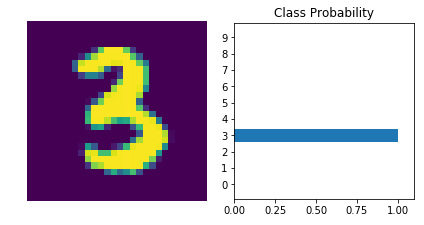

In [74]:
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1,784)

# Turn off gradient to speed up this part

with torch.no_grad():
    logps = model.forward(img)
    
#Output of the network are logits, need to take softmax for probabilities

ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)